<a href="https://colab.research.google.com/github/yorketh/machine-learning/blob/master/Multiclass_Siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook attempts to solve multiclass classification problem via using various types of NNs, including Siamese and RoBERTa.

In [ ]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import sklearn
import xgboost
from tqdm import tqdm
import torch
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
from torch.utils.data import TensorDataset, DataLoader
from string import punctuation
import re
import torch.nn.functional as F
import math
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
import torchtext
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

In [ ]:
from sklearn.model_selection import train_test_split
import zipfile
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from collections import defaultdict
from textwrap import wrap

!pip install transformers==3

import transformers
from transformers import BertModel, BertTokenizer, AdamW,  \
get_linear_schedule_with_warmup, BertForSequenceClassification, RobertaModel, RobertaTokenizer


import random

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

     |████████████████████████████████| 754 kB 5.5 MB/s 
     |████████████████████████████████| 895 kB 24.0 MB/s 
     |████████████████████████████████| 1.2 MB 35.6 MB/s 
     |████████████████████████████████| 3.0 MB 33.8 MB/s 


In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/task.zip', 'r') as zip_ref:
    zip_ref.extractall('task')

In [ ]:
train = pd.read_csv('/content/task/task/train_data.csv')
valid = pd.read_csv('/content/task/task/validation_set.csv')

In [ ]:
train.head(10)

,Class_ID,Phrases
0,22806315,50 MW Floating Solar PV tender document
1,22806315,ABC Design guideline
2,22806315,access control to roof top
3,22806315,After drinking water mr Koh he farted why
4,22806315,Any increment in price for 2020
5,22806315,any permit for carnival
6,22806315,Any vacancy at wsn Johor
7,22806315,application for fire hydrant relocation
8,22806315,Apply for gas
9,22806315,approval for permit through ltaPROMPT


In [ ]:
valid.head(10)

,Phrases,Class_ID
0,Is there a difference between the rates betwee...,27818940
1,Is there a difference between the water rates ...,27818940
2,Can you please recommend a licensed plumber to...,27818847
3,Can a building be served by 100 newater if the...,27818888
4,Water supply stopped,27818909
5,How do i get non potable NEWater to a lab in a...,22809639
6,Lab use,22813502
7,What is pub email address,33741874
8,Water got poison,34879242
9,Water got germ,34879242


In [ ]:
# 358 unique classes in train set
len(train.Class_ID.unique())

358

In [ ]:
# 140 unique classes in valid set
len(valid.Class_ID.unique())

140

In [ ]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [ ]:
train.describe()

,Class_ID
count,9693
mean,29276900
std,5058443
min,22806315
25%,27818847
50%,27956629
75%,33741874
max,53256124


In [ ]:
valid.describe()

,Class_ID
count,1062
mean,29490632
std,5735918
min,22806315
25%,27810629
50%,27818928
75%,33741874
max,53255308


In [ ]:
# class_id=36136698 is not in train set
f = [i for i in valid.Class_ID.unique() if i not in train.Class_ID.unique()]
f

[36136698]

In [ ]:
valid[valid.Class_ID==f[0]]

,Phrases,Class_ID
87,who is responsible for mainting the external w...,36136698
591,Can i know who is the term contractor for wate...,36136698


In [ ]:
# class_id=22813502 is 10% of all train samples
train.groupby('Class_ID').count().Phrases.sort_values(ascending=False)

Class_ID
22813502    962
27818896    682
22809639    539
33741874    486
22806315    380
           ... 
27964707      1
27964710      1
27964718      1
27957957      1
27966415      1
Name: Phrases, Length: 358, dtype: int64

Text(0, 0.5, 'Frequency')

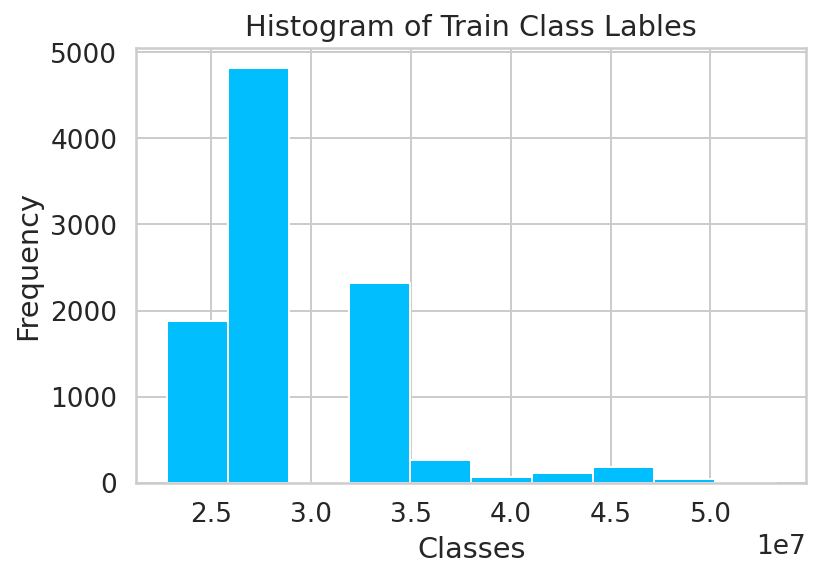

In [ ]:
plt.hist(train.Class_ID)

plt.title('Histogram of Train Class Lables')
plt.xlabel('Classes')
plt.ylabel('Frequency')

In [ ]:
valid.groupby('Class_ID').count().Phrases.sort_values(ascending=False)

Class_ID
22813502    107
33741874     87
22806315     81
27818896     73
34879242     49
           ... 
53254667      1
27956615      1
27882870      1
27855908      1
32399450      1
Name: Phrases, Length: 140, dtype: int64

Text(0, 0.5, 'Frequency')

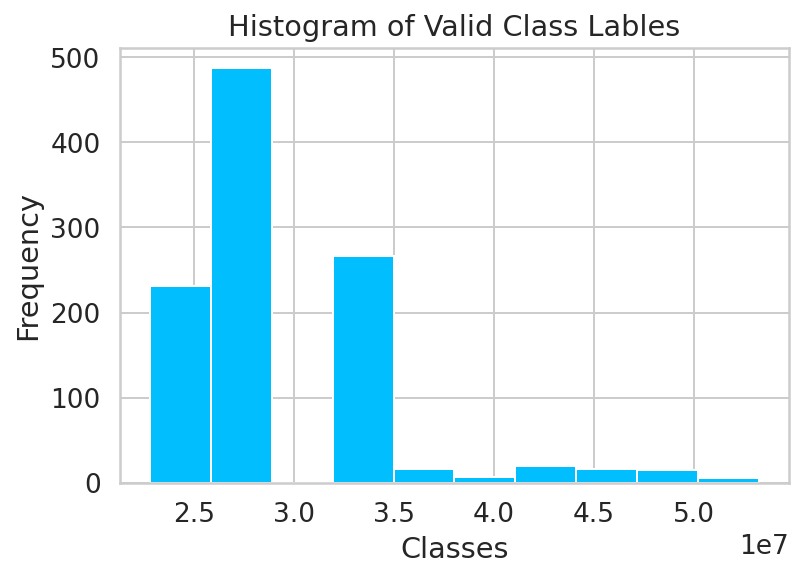

In [ ]:
plt.hist(valid.Class_ID)

plt.title('Histogram of Valid Class Lables')
plt.xlabel('Classes')
plt.ylabel('Frequency')

In [ ]:
train.duplicated().sum()

0

In [ ]:
valid.duplicated().sum()

0

In [ ]:
# 74 duplicated phrases in train set
train.Phrases.duplicated().sum()

74

In [ ]:
valid.Phrases.duplicated().sum()

0

In [ ]:
duplic = train.groupby('Phrases').count().sort_values('Class_ID',ascending=False)
duplic = duplic[duplic.Class_ID>1]
duplic

,Class_ID
Phrases,
Water charges,3
Why is water so expensive,2
Grease trap,2
form E,2
how to get a meter,2
...,...
how to apply temporary supply,2
what is metering east number,2
What are the documents to be submitted for TOP,2


In [ ]:
# this phrase has 3 different labels
train[train.Phrases=='Water charges']

,Class_ID,Phrases
1717,22813502,Water charges
4350,27818940,Water charges
4469,27818973,Water charges


In [ ]:
train[train.Phrases.duplicated(keep=False)].sort_values('Phrases')

,Class_ID,Phrases
950,22813502,Any payment for booking of tours
6930,33665762,Any payment for booking of tours
391,22809639,Average recycling rate
966,22813502,Average recycling rate
968,22813502,B
...,...,...
4402,27818940,why is my water bill very high
912,22809639,why pink residue appears on wash basin surface
9322,39869452,why pink residue appears on wash basin surface
913,22809639,why pink residue left on wash basin


In [ ]:
# as much as same phrase could've belonged to different people,
# these would most certainly confuse classifier
train.drop_duplicates(subset=['Phrases'], inplace=True)

In [ ]:
train[train.Phrases.duplicated(keep=False)].sort_values('Phrases')

,Class_ID,Phrases


In [ ]:
# no train phrases in valid set
f1 = [i for i in valid.Phrases if i in train.Phrases]
f1

[]

In [ ]:
valid.drop(valid[valid.Class_ID==f[0]].index, inplace=True)

In [ ]:
df_train = train.copy()
df_test = valid.copy()
df_train['text'] = train['Phrases']
df_train['label'] = train['Class_ID']
df_test['text'] = valid['Phrases']
df_test['label'] = valid['Class_ID']
df_train.drop(['Phrases', 'Class_ID'], axis=1, inplace=True)
df_test.drop(['Phrases', 'Class_ID'], axis=1, inplace=True)

In [ ]:
le = sklearn.preprocessing.LabelEncoder()
df_train['label'] = le.fit_transform(df_train['label'])
df_test['label'] = le.transform(df_test['label'])

Text cleaning, tokenization, lemmatizing

In [ ]:
def clean(sentence): 
    
    sentence = sentence.replace("`", "'")
     # ... and ..
    sentence = sentence.replace('...', ' ... ')
    if '...' not in sentence:
        sentence = sentence.replace('..', ' .. ') 

   
    # Urls
    sentence = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", sentence)
    sentence = re.sub('\w*\d\w*', '', sentence)
    sentence = re.sub('https?://\S+|www\.\S+', '', sentence)
    
    # Contractions
    
    sentence = sentence.lower()


    sentence = re.sub(r"im", "i am", sentence)
    sentence = re.sub(r"plumberto", "plumber to", sentence)
    sentence = re.sub(r" ww", "", sentence)
    sentence = re.sub(r"wasnt", "was not", sentence)
    sentence = re.sub(r"soo", "so", sentence)
    sentence = re.sub(r"nm", "never mind", sentence)
    sentence = re.sub(r"yer", "your", sentence)
    sentence = re.sub(r"gorjuz", "gorgeous", sentence)
    sentence = re.sub(r" u ", " you ", sentence)
    
    sentence = re.sub(r"btw", "by the way", sentence)
    sentence = re.sub(r"sooo", "so", sentence)
    sentence = re.sub(r"hes", "he is", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"there's", "there is", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"they're", "they are", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"wasn't", "was not", sentence)
    
    sentence = re.sub(r"aren't", "are not", sentence)
    sentence = re.sub(r"isn't", "is not", sentence)
    sentence = re.sub(r"havent", "have not", sentence)
    sentence = re.sub(r"haven't", "have not", sentence)
    sentence = re.sub(r"hasn't", "has not", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"shouldn't", "should not", sentence)
    sentence = re.sub(r"wouldn't", "would not", sentence)
    sentence = re.sub(r"i'm", "i am", sentence)
    
    sentence = re.sub(r"here's", "here is", sentence)
    sentence = re.sub(r"you've", "you have", sentence)
   
    sentence = re.sub(r"we're", "we are", sentence)
    sentence = re.sub(r"what's", "what is", sentence)
    sentence = re.sub(r"couldn't", "could not", sentence)
    sentence = re.sub(r"we've", "we have", sentence)
   
    sentence = re.sub(r"who's", "who is", sentence)
    
    sentence = re.sub(r"y'all", "you all", sentence)
    
    sentence = re.sub(r"would've", "would have", sentence)
    sentence = re.sub(r"it'll", "it will", sentence)
    sentence = re.sub(r"we'll", "we will", sentence)
    
    sentence = re.sub(r"he'll", "he will", sentence)
    sentence = re.sub(r"they'll", "they will", sentence)
    sentence = re.sub(r"they'd", "they would", sentence)
    
    sentence = re.sub(r"they've", "they have", sentence)
    sentence = re.sub(r"i'd", "i would", sentence)
    sentence = re.sub(r"should've", "should have", sentence)
    
    sentence = re.sub(r"where's", "where is", sentence)
    
    sentence = re.sub(r"we'd", "we would", sentence)
    sentence = re.sub(r"i'll", "i will", sentence)
    sentence = re.sub(r"weren't", "were not", sentence)
    
    sentence = re.sub(r"let's", "let us", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"can't", "can not", sentence)
    sentence = re.sub(r"don't", "do not", sentence)
    sentence = re.sub(r"you're", "you are", sentence)
    sentence = re.sub(r"i've", "I have", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"doesn't", "does not", sentence)
    sentence = re.sub(r"didn't", "did not", sentence)
    sentence = re.sub(r"ain't", "am not", sentence)
    sentence = re.sub(r"you'll", "you will", sentence)
    sentence = re.sub(r"you'd", "you would", sentence)
    sentence = re.sub(r"haven't", "have not", sentence)
    sentence = re.sub(r"could've", "could have", sentence)
    sentence = re.sub(r"youve", "you have", sentence) 
    sentence = re.sub(r"donbt", "do not", sentence)
    sentence = re.sub(r"dont", "do not", sentence)
    sentence = re.sub(r"thats", "that is", sentence) 
    
    
    
    # Special characters
    sentence = re.sub(r"\x89Û_", "", sentence)
    sentence = re.sub(r"\x89ÛÒ", "", sentence)
    sentence = re.sub(r"\x89ÛÓ", "", sentence)
    
    sentence = re.sub(r"\x89ÛÏ", "", sentence)
    
    sentence = re.sub(r"\x89Û÷", "", sentence)
    sentence = re.sub(r"\x89Ûª", "", sentence)
    sentence = re.sub(r"\x89Û\x9d", "", sentence)
    sentence = re.sub(r"å_", "", sentence)
    sentence = re.sub(r"\x89Û¢", "", sentence)
    sentence = re.sub(r"\x89Û¢åÊ", "", sentence)
    
    sentence = re.sub(r"åÊ", "", sentence)
    sentence = re.sub(r"åÈ", "", sentence)
    
    sentence = re.sub(r"Ì©", "e", sentence)
    sentence = re.sub(r"å¨", "", sentence)
    
    sentence = re.sub(r"åÇ", "", sentence)
    
    sentence = re.sub(r"åÀ", "", sentence)

    # Words with punctuations and special characters
    punctuations = '@#!?+&[]-%.*:/();$=><|{}^'
    for p in punctuations:
        sentence = sentence.replace(p, f' {p} ')
    
    # Character entity references
    sentence = re.sub(r"&gt;", ">", sentence)
    sentence = re.sub(r"&lt;", "<", sentence)
    sentence = re.sub(r"&amp;", "&", sentence)
    sentence = re.sub('<.?>+', '', sentence)
    sentence = re.sub('[%s]' % re.escape(punctuation), '', sentence)
    sentence = re.sub('\n', '', sentence)
    sentence = re.sub('\[.?\]', '', sentence)

    
    return sentence

def prepr(Corpus):
  # Step - a : Remove blank rows if any.
  Corpus['text'].dropna(inplace=True)
  # Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
  
  Corpus['text'] = [entry.lower() for entry in Corpus['text']]
  # Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
  Corpus['text']= [word_tokenize(entry) for entry in Corpus['text']]
  # Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
  # WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
  tag_map = defaultdict(lambda : wn.NOUN)
  tag_map['J'] = wn.ADJ
  tag_map['V'] = wn.VERB
  tag_map['R'] = wn.ADV
  for index,entry in enumerate(Corpus['text']):
      # Declaring Empty List to store the words that follow the rules for this step
      Final_words = []
      s = ''
      # Initializing WordNetLemmatizer()
      word_Lemmatized = WordNetLemmatizer()
      # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
      for word, tag in pos_tag(entry):
          # Below condition is to check for Stop words and consider only alphabets
          if word not in stopwords.words('english') and word.isalpha():
              word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
              Final_words.append(word_Final)
      # The final processed set of words for each iteration will be stored in 'text_final'
      for i in Final_words:
        s+=(i+' ')
      
      Corpus.loc[index,'text_final'] = s[:-1]
      

  return Corpus

train1 = df_train.copy()
valid1 = df_test.copy()
train1['text'] = train1['text'].apply(lambda s: clean(s))
valid1['text'] = valid1['text'].apply(lambda s: clean(s))


In [ ]:
train1

,text,label
0,mw floating solar pv tender document,0
1,abc design guideline,0
2,access control to roof top,0
3,after drinking water mr koh he farted why,0
4,any increment in price for,0
...,...,...
9688,may i know how feces is treated in singapore,355
9689,is the pub flood management map working,356
9690,where can i find the flood management map,356
9691,for smart shower how to see the temp of water,357


In [ ]:
valid1

,text,label
0,is there a difference between the rates betwee...,47
1,is there a difference between the water rates ...,47
2,can you please recommend a licensed plumber to...,33
3,can a building be served by newater if the ow...,39
4,water supply stopped,42
...,...,...
1057,need license plumber to replace washing basin,33
1058,submit meter reading,254
1059,hi there how i want to apply job at pub,3
1060,did you have any web site to apply any job opp...,3


In [ ]:
train1 =  prepr(train1.reset_index())
valid1 =  prepr(valid1.reset_index())

In [ ]:
train1

,index,text,label,text_final
0,0,"[mw, floating, solar, pv, tender, document]",0,mw float solar pv tender document
1,1,"[abc, design, guideline]",0,abc design guideline
2,2,"[access, control, to, roof, top]",0,access control roof top
3,3,"[after, drinking, water, mr, koh, he, farted, ...",0,drink water mr koh fart
4,4,"[any, increment, in, price, for]",0,increment price
...,...,...,...,...
9614,9688,"[may, i, know, how, feces, is, treated, in, si...",355,may know feces treat singapore
9615,9689,"[is, the, pub, flood, management, map, working]",356,pub flood management map work
9616,9690,"[where, can, i, find, the, flood, management, ...",356,find flood management map
9617,9691,"[for, smart, shower, how, to, see, the, temp, ...",357,smart shower see temp water


In [ ]:
valid1

,index,text,label,text_final
0,0,"[is, there, a, difference, between, the, rates...",47,difference rate hdb flat private property
1,1,"[is, there, a, difference, between, the, water...",47,difference water rate hdb flat private property
2,2,"[can, you, please, recommend, a, licensed, plu...",33,please recommend licensed plumber install wate...
3,3,"[can, a, building, be, served, by, newater, if...",39,building serve newater owner willing
4,4,"[water, supply, stopped]",42,water supply stop
...,...,...,...,...
1055,1057,"[need, license, plumber, to, replace, washing,...",33,need license plumber replace wash basin
1056,1058,"[submit, meter, reading]",254,submit meter reading
1057,1059,"[hi, there, how, i, want, to, apply, job, at, ...",3,hi want apply job pub
1058,1060,"[did, you, have, any, web, site, to, apply, an...",3,web site apply job opportunity


In [ ]:
all_sentences = list(train1['text_final'])
all_sentences_val = list(valid1['text_final'])

In [ ]:
all_sentences[:2]

['mw float solar pv tender document', 'abc design guideline']

In [ ]:
len(all_sentences+all_sentences_val)

10679

Pretrained Glove embeddings

In [ ]:
vocabulary = []

for i in all_sentences+all_sentences_val:
  for y in i.split():
    if y not in vocabulary:
      vocabulary.append(y)

# pretrained glove embeddings for twitter with dim of 200
glove = torchtext.vocab.GloVe(name="twitter.27B", dim=200)


matrix_len = len(vocabulary)
weights_matrix = np.zeros((matrix_len+1, 200))
#weights_matrix[0] = np.random.normal(scale=0.6, size=(100, ))

words_found = 0

for i, word in enumerate(vocabulary, start=1):
    if float(torch.sum(glove[word]))!=0.:
        weights_matrix[i] = glove[word]
        words_found += 1
    else:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(200, ))

print(f'Words found: {words_found} out of {len(vocabulary)}')

.vector_cache/glove.twitter.27B.zip: 1.52GB [04:55, 5.14MB/s]                            
100%|█████████▉| 1193513/1193514 [01:51<00:00, 10746.56it/s]


Words found: 3691 out of 4480


In [ ]:
# function for inserting embeddings into neural net
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': torch.tensor(weights_matrix)})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

voc_dic = {i:vocabulary.index(i)+1 for i in vocabulary}
print('Dictionary: ', voc_dic)


Dictionary:  {'mw': 1, 'float': 2, 'solar': 3, 'pv': 4, 'tender': 5, 'document': 6, 'abc': 7, 'design': 8, 'guideline': 9, 'access': 10, 'control': 11, 'roof': 12, 'top': 13, 'drink': 14, 'water': 15, 'mr': 16, 'koh': 17, 'fart': 18, 'increment': 19, 'price': 20, 'permit': 21, 'carnival': 22, 'vacancy': 23, 'wsn': 24, 'johor': 25, 'application': 26, 'fire': 27, 'hydrant': 28, 'relocation': 29, 'apply': 30, 'gas': 31, 'approval': 32, 'ltaprompt': 33, 'ai': 34, 'ask': 35, 'judyhdb': 36, 'whar': 37, 'service': 38, 'reach': 39, 'bsc': 40, 'saint': 41, 'george': 42, 'tower': 43, 'burner': 44, 'isnt': 45, 'respond': 46, 'architect': 47, 'work': 48, 'fish': 49, 'whampoa': 50, 'river': 51, 'bring': 52, 'roast': 53, 'goose': 54, 'singapore': 55, 'buy': 56, 'cooker': 57, 'n': 58, 'oven': 59, 'pub': 60, 'clam': 61, 'krangi': 62, 'get': 63, 'sandbag': 64, 'number': 65, 'wdmi': 66, 'know': 67, 'link': 68, 'inlis': 69, 'website': 70, 'use': 71, 'hose': 72, 'car': 73, 'wash': 74, 'architects': 75, 'a

In [ ]:
weights_matrix.shape

(4481, 200)

In [ ]:
sentences_num = []

for i in all_sentences+all_sentences_val:
  sentences_num.append([voc_dic[y] for y in i.split()])

print('Tokenized: ', sentences_num[1])

Tokenized:  [7, 8, 9]


In [ ]:
#sentence zero-padding
padded = pad_sequences(sentences_num, padding='post')

print('Padded: ', padded[0])

Padded:  [1 2 3 4 5 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
vocab_reversed = {v:k for k,v in voc_dic.items()}

print('Text', [vocab_reversed[i] if i!=0 else 0 for i in padded[0]])

Text ['mw', 'float', 'solar', 'pv', 'tender', 'document', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
y_train = df_train.label.to_numpy()
y_test = df_test.label.to_numpy()

In [ ]:
padded

array([[  1,   2,   3, ...,   0,   0,   0],
       [  7,   8,   9, ...,   0,   0,   0],
       [ 10,  11,  12, ...,   0,   0,   0],
       ...,
       [296, 304,  52, ...,   0,   0,   0],
       [547,  44,  89, ...,   0,   0,   0],
       [174,  12, 136, ...,   0,   0,   0]], dtype=int32)

Some classical algos on simply tokenized sentences, 16% accuracy, a little bit above naive baseline

In [ ]:
xgbc = xgboost.XGBClassifier(num_estimators=1000, lr=0.01)
nb = sklearn.naive_bayes.MultinomialNB()
svmc = sklearn.svm.SVC()

preds = []

for clf in [xgbc, nb, svmc]:
  clf.fit(padded[:len(train),:], y_train)
  preds.append(clf.predict(padded[len(train):,:]))

for p in preds:
  print(accuracy_score(p, y_test))

0.16981132075471697
0.0009433962264150943
0.09528301886792453


In [ ]:
#baseline by the most frequent class
df_test.groupby('label').count().sort_values('text').iloc[-1].values[0]/len(df_test)*100

10.09433962264151

Straightforward LSTM-based classifier + self-attention (not as in Transformers, simplier one, see my [other experiment](https://github.com/yorketh/machine-learning/blob/master/tweets_attention.ipynb) with this module)

In [ ]:
train_data = TensorDataset(torch.from_numpy(padded[:len(train),:]), torch.tensor(y_train))
valid_data = TensorDataset(torch.from_numpy(padded[len(train):,:]), torch.tensor(y_test))


batch_size = 30

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, 
                          drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, 
                          drop_last=True)


train_on_gpu = torch.cuda.is_available()

In [ ]:
class Sent(nn.Module):
    def __init__(self, weights_matrix, hidden_size, linear_hid, d, r):
        super(Sent, self).__init__()
        self.hidden_size = hidden_size
        self.d = d
        self.r = r
        self.linear_hid = linear_hid
        self.embed, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)

        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True, 
                            bidirectional=True)
        self.w1 = nn.Linear(2*hidden_size, d, bias=False)
        self.tanh = nn.Tanh()
        self.w2 = nn.Linear(d, r, bias = False)
        self.soft = nn.Softmax(dim=1)
        self.drop = nn.Dropout(.3)

        self.lin1 = nn.Linear(2*hidden_size, linear_hid)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(linear_hid, train.Class_ID.nunique())

      
    def forward(self, x, hidden):
      
      batch_size = x.size(0)
      x = x.long()
      em = self.embed(x)
      
      out, hidden = self.lstm(em, hidden)
      
      out = self.drop(out)
     
      _w = self.tanh(self.w1(out))
      w = self.w2(_w)
      w = torch.abs(w)
      
      
      att = self.soft(w)
      
      att = w.transpose(dim0=1, dim1=2)
    
      m = torch.matmul(att, out)
      m = m.mean(dim=1)
      
      m = m.view(batch_size, -1)
      
      x = self.relu(self.lin1(m))
     
      x = self.lin2(x)

      return x, hidden

    def initHidden(self, batch_size):
        weight = next(self.parameters()).data
        if train_on_gpu:
          hidden = (weight.new(2, batch_size, self.hidden_size).zero_().cuda(), #//2
                  weight.new(2, batch_size, self.hidden_size).zero_().cuda())
        else:
          hidden = (weight.new(2, batch_size, self.hidden_size).zero_().cpu(), #//2
                  weight.new(2, batch_size, self.hidden_size).zero_().cpu())
        return hidden


hidden_size = 32
d = 10
r = 1
linear_hid = 200

net = Sent(weights_matrix, hidden_size, linear_hid, d, r)


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

print(f'Number of parameters: {count_parameters(net)}')

optimizer = torch.optim.AdamW(net.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 30
counter = 0
clip = 5
print_every = 200
count_ep = 0

if train_on_gpu:
    net.cuda()

net.train()

In [ ]:
for epoch in range(epochs):
  val_attention = []
  input_text = []
  selected = []
  my_texts = []
  result = []
  selectedd = []
  atten = []
  
  count_ep+=1
  
  train_res = []
  train_lab = []
  valid_res = []
  valid_lab = []
  hidden = net.initHidden(batch_size)
  for input, label in train_loader:

    counter += 1
    if train_on_gpu:
        input, label = input.cuda(), label.cuda()
    
    hidden = tuple([e.data for e in hidden])
    
    net.zero_grad()
    
    output, hidden= net(input, hidden)
    
    for i in output:
      train_res.append(int(torch.argmax(i)))
    
    for i in label:
      train_lab.append(int(i))
    
    loss = criterion(output,label.long())
    loss.backward()
    
    
    optimizer.step()
    
    acc = np.sum(np.array(train_res) == np.array(train_lab)) / len(np.array(train_lab))

  valid_hidden_state = net.initHidden(batch_size)
  valid_losses = []
  valid_losses1 = []
  net.eval()
  for input, label in valid_loader:
    
    valid_hidden_state = tuple([e.data for e in valid_hidden_state])
    if train_on_gpu:
      input, label = input.cuda(), label.cuda()

    val_output, valid_hidden_state = net(input, valid_hidden_state)

    for i in val_output:
      valid_res.append(int(torch.argmax(i)))
    for i in label:
      valid_lab.append(int(i))

    val_loss = criterion(val_output, label.long())
    
    valid_losses.append(val_loss.item())
    
    
    val_acc = np.sum(np.array(valid_res) == np.array(valid_lab)) / len(np.array(valid_lab))
    
    
  net.train()

  print(f'Epoch: {epoch + 1}/{epochs}')
  print(f'Step: {counter}')
  print(f'Train_acc: {acc}')
  print(f'Valid_acc: {val_acc}')
  
  print(f'Loss Cross: :{loss.item()}')
  print(f'Val_loss Cross: {np.mean(valid_losses)}')

  
  

Epoch: 1/30
Step: 320
Train_acc: 0.12427083333333333
Valid_acc: 0.17047619047619048
Loss Cross: :4.5163960456848145
Val_loss Cross: 3.740082311630249
Epoch: 2/30
Step: 640
Train_acc: 0.21260416666666668
Valid_acc: 0.2580952380952381
Loss Cross: :3.793637275695801
Val_loss Cross: 3.2998247146606445
Epoch: 3/30
Step: 960
Train_acc: 0.27145833333333336
Valid_acc: 0.31142857142857144
Loss Cross: :3.99200439453125
Val_loss Cross: 2.9870305810655866
Epoch: 4/30
Step: 1280
Train_acc: 0.3101041666666667
Valid_acc: 0.3333333333333333
Loss Cross: :2.274887800216675
Val_loss Cross: 2.8201943056924
Epoch: 5/30
Step: 1600
Train_acc: 0.3509375
Valid_acc: 0.3638095238095238
Loss Cross: :2.4597456455230713
Val_loss Cross: 2.677168345451355
Epoch: 6/30
Step: 1920
Train_acc: 0.3807291666666667
Valid_acc: 0.38666666666666666
Loss Cross: :2.5303280353546143
Val_loss Cross: 2.6062708173479354
Epoch: 7/30
Step: 2240
Train_acc: 0.40177083333333335
Valid_acc: 0.3923809523809524
Loss Cross: :2.2126762866973877

In [ ]:
valid_lab, valid_res = [],[]
valid_loader1 = DataLoader(valid_data, shuffle=False, batch_size=1, 
                          )
valid_hidden_state = net.initHidden(1)

net.eval()
for input, label in valid_loader1:
  
  valid_hidden_state = tuple([e.data for e in valid_hidden_state])
  if train_on_gpu:
    input, label = input.cuda(), label.cuda()

  val_output, valid_hidden_state = net(input, valid_hidden_state)

  
  valid_res.append(int(torch.argmax(val_output)))
  
  valid_lab.append(int(label))


In [ ]:
accuracy_score(valid_res, y_test)

0.4518867924528302

About 45% accuracy on valid set, NN heavily overfits, but early stopping won't influence valid results

In [ ]:
pred_df = pd.DataFrame()
pred_df['true'] = y_test
pred_df['pred'] = valid_res
pred_df['correct'] = valid_res==y_test

In [ ]:
pred_df

,true,pred,correct
0,47,1,False
1,47,1,False
2,33,33,True
3,39,39,True
4,42,43,False
...,...,...,...
1055,33,33,True
1056,254,254,True
1057,3,3,True
1058,3,3,True


Ratio of correctly/incorrectly prediicted samples for each class

In [ ]:
correct_ratio = (pred_df.groupby('true').sum()['correct']/pred_df.groupby('true').count()['correct']).sort_values(ascending=False)
correct_ratio

true
125    1.0
313    1.0
203    1.0
201    1.0
194    1.0
      ... 
211    0.0
228    0.0
241    0.0
245    0.0
186    0.0
Name: correct, Length: 139, dtype: float64

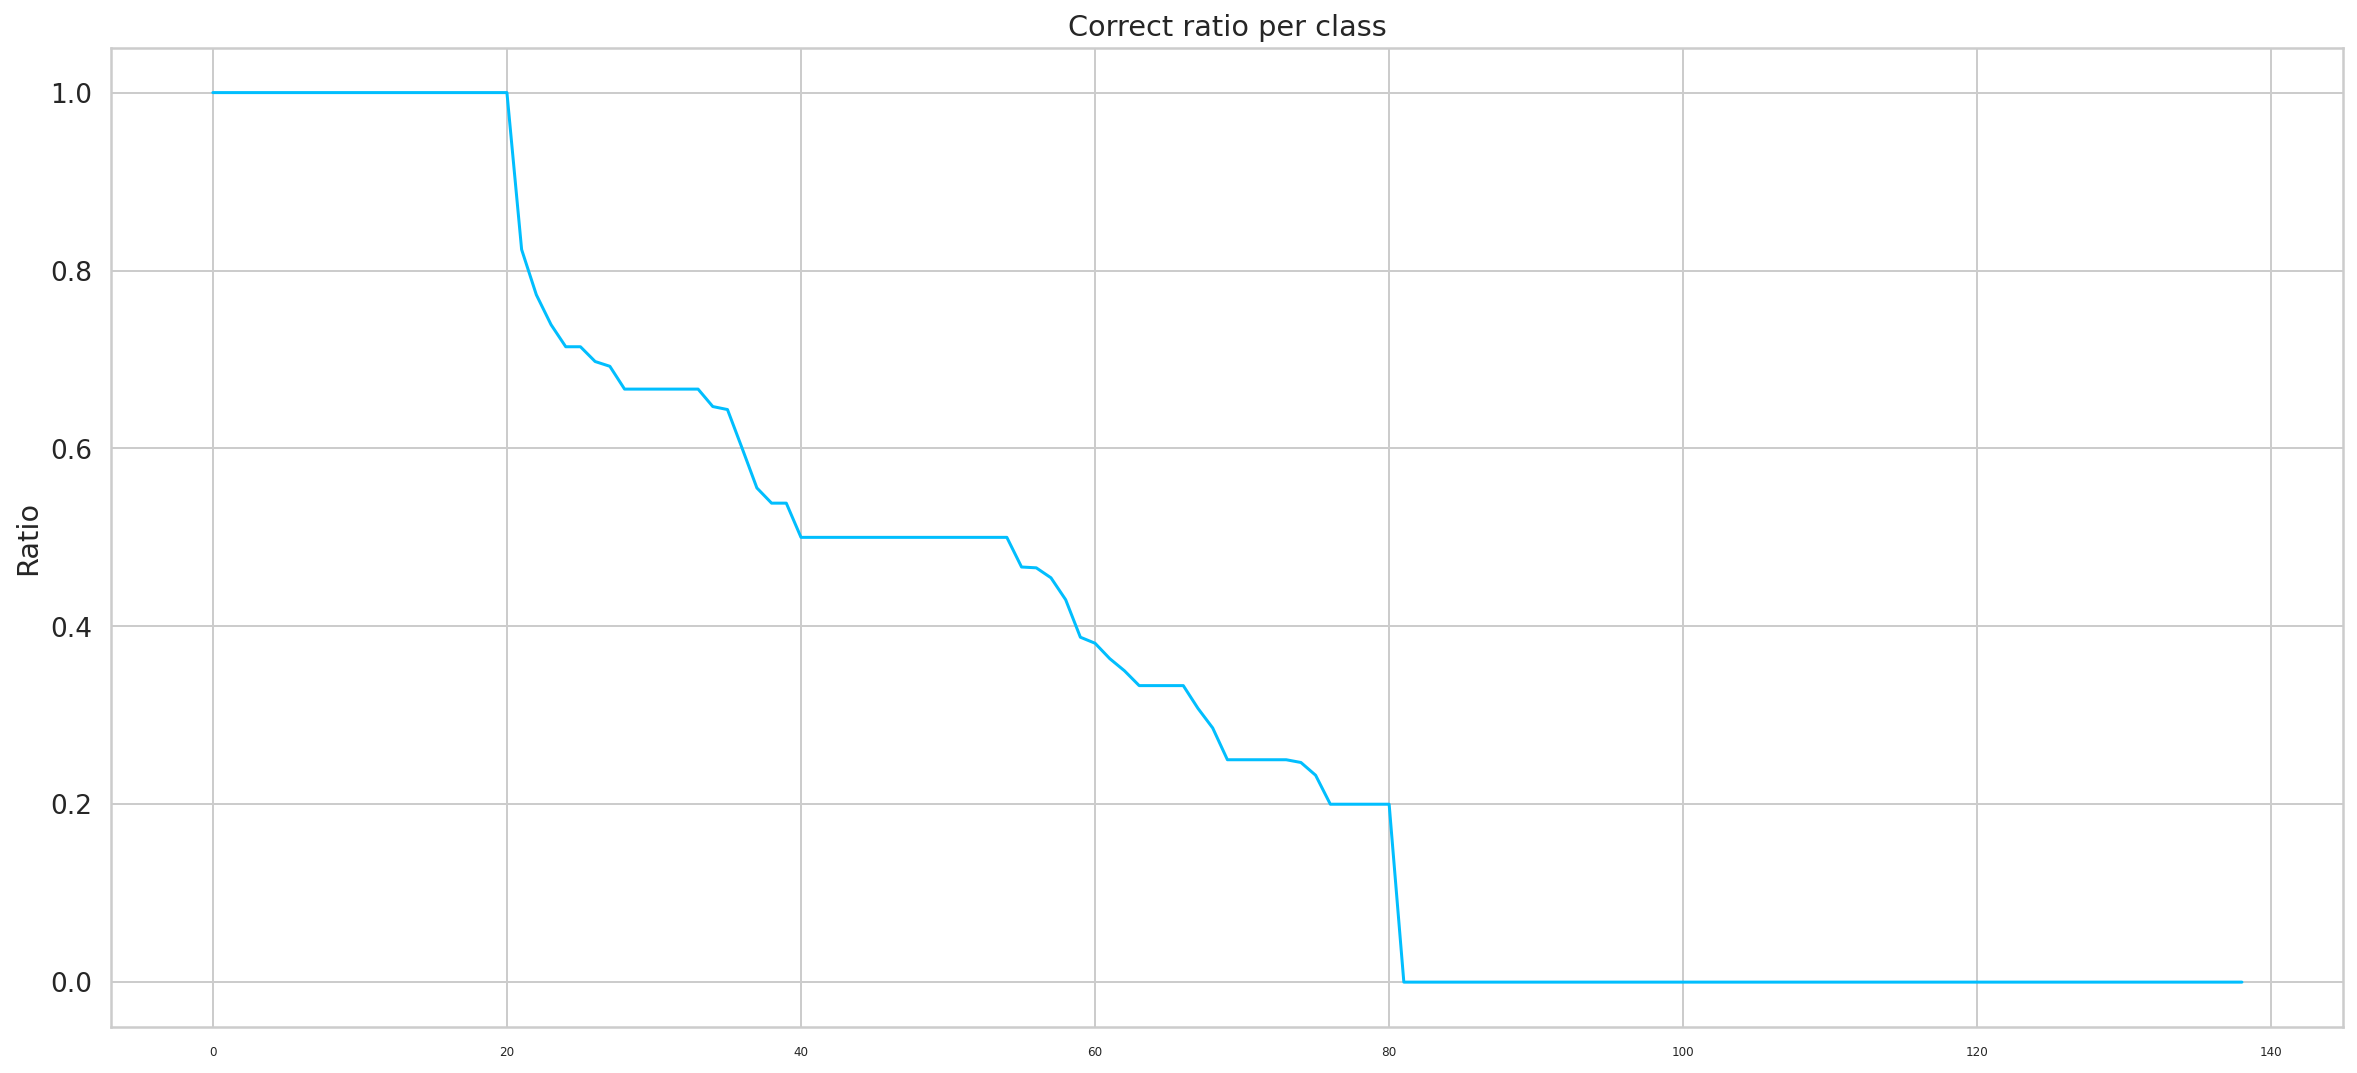

In [ ]:
plt.figure(figsize=(20,9))
plt.title('Correct ratio per class')
plt.ylabel('Ratio')
plt.plot(range(len(correct_ratio)), correct_ratio.values)

Siamese network. 

Same architecture, only this time two NNs learn to distinguish between pairs of samples of the same and different classes, classifying them in binary fashion. That is, a pair of the same class should be 1, a pair of different classes should be 0. Same goes for inference, we don't classify new samples but rather decide what previously classified sample they are most similar to.

I went for this approach keeping in mind that siamese networks work good for limited number of instances and large number of classes while traditional supervised classification doesn't handle these types of problems very well. Unfortunetely, this approach failed completely.

In [ ]:
#drop classes of 1 samples, can't form pairs from them
grouped = train.groupby('Class_ID').count()
train.drop(train[train.Class_ID.isin(grouped[grouped['Phrases']==1].index)].index, inplace=True)

In [ ]:
#no longer need to drop classes absent in train set
valid = pd.read_csv('/content/task/task/validation_set.csv')

In [ ]:
df_train = train.copy()
df_test = valid.copy()
df_train['text'] = train['Phrases']
df_train['label'] = train['Class_ID']
df_test['text'] = valid['Phrases']
df_test['label'] = valid['Class_ID']
df_train.drop(['Phrases', 'Class_ID'], axis=1, inplace=True)
df_test.drop(['Phrases', 'Class_ID'], axis=1, inplace=True)

In [ ]:
le = sklearn.preprocessing.LabelEncoder()
df_train['label'] = le.fit_transform(df_train['label'])
df_test['label'] = df_test['label'].apply(lambda x:list(le.classes_).index(x) if x in le.classes_ else len(le.classes_))

In [ ]:
train1 = df_train.copy()
valid1 = df_test.copy()
train1['text'] = train1['text'].apply(lambda s: clean(s))
valid1['text'] = valid1['text'].apply(lambda s: clean(s))
train1 =  prepr(train1.reset_index())
valid1 =  prepr(valid1.reset_index())
all_sentences = list(train1['text_final'])
all_sentences_val = list(valid1['text_final'])

In [ ]:
vocabulary = []

for i in all_sentences+all_sentences_val:
  for y in i.split():
    if y not in vocabulary:
      vocabulary.append(y)

glove = torchtext.vocab.GloVe(name="twitter.27B", dim=200)


matrix_len = len(vocabulary)
weights_matrix = np.zeros((matrix_len+1, 200))

words_found = 0

for i, word in enumerate(vocabulary, start=1):
    if float(torch.sum(glove[word]))!=0.:
        weights_matrix[i] = glove[word]
        words_found += 1
    else:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(200, ))

print(f'Words found: {words_found} out of {len(vocabulary)}')

.vector_cache/glove.twitter.27B.zip: 1.52GB [05:41, 4.45MB/s]                            
100%|█████████▉| 1193513/1193514 [01:57<00:00, 10141.49it/s]


Words found: 3682 out of 4471


In [ ]:
# function for inserting embeddings into neural net
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': torch.tensor(weights_matrix)})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

voc_dic = {i:vocabulary.index(i)+1 for i in vocabulary}
print('Dictionary: ', voc_dic)


Dictionary:  {'mw': 1, 'float': 2, 'solar': 3, 'pv': 4, 'tender': 5, 'document': 6, 'abc': 7, 'design': 8, 'guideline': 9, 'access': 10, 'control': 11, 'roof': 12, 'top': 13, 'drink': 14, 'water': 15, 'mr': 16, 'koh': 17, 'fart': 18, 'increment': 19, 'price': 20, 'permit': 21, 'carnival': 22, 'vacancy': 23, 'wsn': 24, 'johor': 25, 'application': 26, 'fire': 27, 'hydrant': 28, 'relocation': 29, 'apply': 30, 'gas': 31, 'approval': 32, 'ltaprompt': 33, 'ai': 34, 'ask': 35, 'judyhdb': 36, 'whar': 37, 'service': 38, 'reach': 39, 'bsc': 40, 'saint': 41, 'george': 42, 'tower': 43, 'burner': 44, 'isnt': 45, 'respond': 46, 'architect': 47, 'work': 48, 'fish': 49, 'whampoa': 50, 'river': 51, 'bring': 52, 'roast': 53, 'goose': 54, 'singapore': 55, 'buy': 56, 'cooker': 57, 'n': 58, 'oven': 59, 'pub': 60, 'clam': 61, 'krangi': 62, 'get': 63, 'sandbag': 64, 'number': 65, 'wdmi': 66, 'know': 67, 'link': 68, 'inlis': 69, 'website': 70, 'use': 71, 'hose': 72, 'car': 73, 'wash': 74, 'architects': 75, 'a

In [ ]:
sentences_num = []

for i in all_sentences+all_sentences_val:
  sentences_num.append([voc_dic[y] for y in i.split()])

print('Tokenized: ', sentences_num[1])

Tokenized:  [7, 8, 9]


In [ ]:
padded = pad_sequences(sentences_num, padding='post')

print('Padded: ', padded[0])

Padded:  [1 2 3 4 5 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
y_train = df_train.label.to_numpy()
y_test = df_test.label.to_numpy()

In [ ]:
# dataset for siamese network
# for even iterations we fetch a pair of samples of the same class (possibly, same sample), label 1
# for odd iterations a pair of different classes (label 0)
class SiamDataset(Dataset):
    
    def __init__(self, categories, x_train, y_train, df):
        self.categories = categories
        self.x_train = x_train
        self.y_train = y_train
        self.df = df.reset_index()
        
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):

        if idx % 2 == 0:
            category = random.choice(self.categories)
            
            ind1,ind2 = random.choice(self.df[self.df['label']==category].index), \
            random.choice(self.df[self.df['label']==category].index)
            
            sen1 = self.x_train[ind1]
            sen2 = self.x_train[ind2]
            
            label = 1.0

        else:
            category1, category2 = random.choice(self.categories), random.choice(self.categories)
            
            ind1, ind2 = random.choice(self.df[self.df['label']==category1].index), \
            random.choice(self.df[self.df['label']==category2].index)
            
            sen1 = self.x_train[ind1]
            sen2 = self.x_train[ind2]
            
            
            while ind1 == ind2:
              ind2 = random.choice(self.df[self.df['label']==category2].index)
              sen2 = self.x_train[ind2]
            
            label = 0.0
            
        return sen1, sen2, torch.from_numpy(np.array([label], dtype=np.float32))  


train_data = SiamDataset(df_train.label.unique(), torch.from_numpy(padded[:len(train),:]), 
                        torch.tensor(y_train), df_train)

In [ ]:
batch_size = 30
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, 
                          drop_last=True)
train_on_gpu = torch.cuda.is_available()

In [ ]:
class Siam(nn.Module):
    def __init__(self, weights_matrix, hidden_size, linear_hid, d, r):
        super(Siam, self).__init__()
        self.hidden_size = hidden_size
        self.d = d
        self.r = r
        self.linear_hid = linear_hid
        self.embed, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)
        #self.embed = nn.Embedding(5329, 200)

        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True, 
                            bidirectional=True)
        self.w1 = nn.Linear(2*hidden_size, d, bias=False)
        self.tanh = nn.Tanh()
        self.w2 = nn.Linear(d, r, bias = False)
        self.soft = nn.Softmax(dim=1)
        self.drop = nn.Dropout(.3)

        self.lin1 = nn.Linear(2*hidden_size, linear_hid)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(linear_hid, 4096)

        

        self.fcOut = nn.Linear(4096,1)


    def forward(self, x1, x2, hidden):
      res = []
      for x in [x1,x2]:
        
        batch_size = x.size(0)
        x = x.long()
        em = self.embed(x)
        
        out, hidden = self.lstm(em, hidden) 
        
        out = self.drop(out)
      
        _w = self.tanh(self.w1(out))
        w = self.w2(_w)
        w = torch.abs(w)
        
        
        att = self.soft(w)
        
        att = w.transpose(dim0=1, dim1=2)
      
        m = torch.matmul(att, out)
        m = m.mean(dim=1)

        
        m = m.view(batch_size, -1)
        
        x = self.relu(self.lin1(m))
      
        x = self.lin2(x)

        res.append(x)

      x = torch.abs(res[0] - res[1])
      x = self.fcOut(x)

      return x, hidden

    def initHidden(self, batch_size):
        weight = next(self.parameters()).data
        if train_on_gpu:
          hidden = (weight.new(2, batch_size, self.hidden_size).zero_().cuda(), #//2
                  weight.new(2, batch_size, self.hidden_size).zero_().cuda())
        else:
          hidden = (weight.new(2, batch_size, self.hidden_size).zero_().cpu(), #//2
                  weight.new(2, batch_size, self.hidden_size).zero_().cpu())
        return hidden


hidden_size = 32
d = 10
r = 1
linear_hid = 200

net = Siam(weights_matrix, hidden_size, linear_hid, d, r)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

print(f'Number of parameters: {count_parameters(net)}')

optimizer = torch.optim.AdamW(net.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()

epochs = 15
counter = 0
clip = 5
print_every = 200
count_ep = 0

if train_on_gpu:
    net.cuda()

net.train()

Number of parameters: 900947


Siam(
  (embed): Embedding(4472, 200)
  (lstm): LSTM(200, 32, batch_first=True, bidirectional=True)
  (w1): Linear(in_features=64, out_features=10, bias=False)
  (tanh): Tanh()
  (w2): Linear(in_features=10, out_features=1, bias=False)
  (soft): Softmax(dim=1)
  (drop): Dropout(p=0.3, inplace=False)
  (lin1): Linear(in_features=64, out_features=200, bias=True)
  (relu): ReLU()
  (lin2): Linear(in_features=200, out_features=4096, bias=True)
  (fcOut): Linear(in_features=4096, out_features=1, bias=True)
)

In [ ]:
sig = nn.Sigmoid()

for epoch in range(epochs):
  val_attention = []
  input_text = []
  selected = []
  my_texts = []
  result = []
  
  count_ep+=1
  
  train_res = []
  train_lab = []
  valid_res = []
  valid_lab = []

  hidden = net.initHidden(batch_size)
  for sen1, sen2, label in train_loader:

    if train_on_gpu: sen1, sen2, label = sen1.cuda(), sen2.cuda(), label.cuda()

    counter += 1
    
    hidden = tuple([e.data for e in hidden])
    
    optimizer.zero_grad()
    
    output, hidden= net(sen1, sen2, hidden)
    
    for i in output:
      
      train_res.append(int(torch.round(sig(i))[0]))
    
    for i in label:
      train_lab.append(int(i))
    
    loss = criterion(output, label)
    loss.backward()
    
    nn.utils.clip_grad_norm_(net.parameters(), clip)
    
    optimizer.step()
    
    acc = np.sum(np.array(train_res) == np.array(train_lab)) / len(np.array(train_lab))
  
  print(f'Epoch: {epoch + 1}/{epochs}')
  print(f'Step: {counter}')
  print(f'Train Acc: {acc}')
  print(f'Train Loss: {loss.item()}')
  
  
  

Epoch: 1/15
Step: 322
Train Acc: 0.6634575569358178
Train Loss: 0.4729063808917999
Epoch: 2/15
Step: 644
Train Acc: 0.7440993788819876
Train Loss: 0.4518949091434479
Epoch: 3/15
Step: 966
Train Acc: 0.7773291925465838
Train Loss: 0.46457555890083313
Epoch: 4/15
Step: 1288
Train Acc: 0.8044513457556935
Train Loss: 0.16229623556137085
Epoch: 5/15
Step: 1610
Train Acc: 0.8217391304347826
Train Loss: 0.5009189248085022
Epoch: 6/15
Step: 1932
Train Acc: 0.8284679089026915
Train Loss: 0.40036943554878235
Epoch: 7/15
Step: 2254
Train Acc: 0.8401656314699792
Train Loss: 0.3916817009449005
Epoch: 8/15
Step: 2576
Train Acc: 0.848343685300207
Train Loss: 0.38278841972351074
Epoch: 9/15
Step: 2898
Train Acc: 0.8586956521739131
Train Loss: 0.33375170826911926
Epoch: 10/15
Step: 3220
Train Acc: 0.8673913043478261
Train Loss: 0.20648974180221558
Epoch: 11/15
Step: 3542
Train Acc: 0.868944099378882
Train Loss: 0.25518688559532166
Epoch: 12/15
Step: 3864
Train Acc: 0.8766045548654244
Train Loss: 0.3054

In [ ]:
torch.save(net.state_dict(), 'siam.pt')

In [ ]:
test_reind = df_test.reset_index()

Test valid accuracy for some of the classes

In [ ]:
test_reind[test_reind.label==44].index

Int64Index([  0,   1,  17,  19,  20,  22,  23,  24,  53, 138, 174, 184, 185,
            217, 479, 480, 481, 482, 531, 604, 737, 739, 787, 796, 943, 944],
           dtype='int64')

In [ ]:
train_reind = df_train.reset_index()

In [ ]:
class_44 = torch.stack([torch.from_numpy(padded[len(train):,:])[i] for i in test_reind[test_reind.label==44].index])

In [ ]:
class_44.shape

torch.Size([26, 22])

In [ ]:
#calculate similarity scores for all of the sentences in the train set

%%time
net.eval()

full_scores = []

for sen in class_44:
  scores = []
  hidden = net.initHidden(1)
  
  for sen1 in torch.from_numpy(padded[:len(train),:]):
    hidden = tuple([e.data for e in hidden])
    if train_on_gpu:
      sen,sen1 = sen.cuda(), sen1.cuda()
    output, hidden= net(sen.unsqueeze(0), sen1.unsqueeze(0), hidden)
    scores.append(output[0])

  full_scores.append(np.argmax(scores))


CPU times: user 14min 10s, sys: 11.5 s, total: 14min 22s
Wall time: 14min 18s


In [ ]:
len(full_scores)

26

In [ ]:
#indices of the most similar sentences in the train set
full_scores

[6452,
 1047,
 1117,
 1117,
 1117,
 1117,
 1047,
 1047,
 1117,
 1117,
 1047,
 1117,
 1117,
 1117,
 1117,
 1117,
 1117,
 1117,
 1117,
 1117,
 1117,
 1117,
 1117,
 1117,
 1117,
 1047]

In [ ]:
#labels of the most similar sentences in the train set
pred_labels = [df_train.loc[i].label for i in full_scores]

In [ ]:
pred_labels

[155,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [ ]:
# ratio of the sentecnes w/ correct labels among chosen
accuracy_score(pred_labels, [44 for i in range(len(pred_labels))])

0.0

In [ ]:
#100% accuracy for a regular NN
test_reind[test_reind.label==125].index

Int64Index([34, 262, 267], dtype='int64')

In [ ]:
class_125 = torch.stack([torch.from_numpy(padded[len(train):,:])[i] for i in test_reind[test_reind.label==125].index])

In [ ]:
#calculate similarity scores for all of the sentences in the train set

%%time
net.eval()

full_scores = []

for sen in class_125:
  scores = []
  hidden = net.initHidden(1)
  
  for sen1 in torch.from_numpy(padded[:len(train),:]):
    hidden = tuple([e.data for e in hidden])
    if train_on_gpu:
      sen,sen1 = sen.cuda(), sen1.cuda()
    output, hidden= net(sen.unsqueeze(0), sen1.unsqueeze(0), hidden)
    scores.append(output[0])

  full_scores.append(np.argmax(scores))


CPU times: user 1min 37s, sys: 1.37 s, total: 1min 38s
Wall time: 1min 38s


In [ ]:
pred_labels = [df_train.loc[i].label for i in full_scores]
accuracy_score(pred_labels, [125 for i in range(len(pred_labels))])

0.0

In [ ]:
class_313 = torch.stack([torch.from_numpy(padded[len(train):,:])[i] for i in test_reind[test_reind.label==313].index])

In [ ]:
#calculate similarity scores for all of the sentences in the train set

%%time
net.eval()

full_scores = []

for sen in class_313:
  scores = []
  hidden = net.initHidden(1)
  
  for sen1 in torch.from_numpy(padded[:len(train),:]):
    hidden = tuple([e.data for e in hidden])
    if train_on_gpu:
      sen,sen1 = sen.cuda(), sen1.cuda()
    output, hidden= net(sen.unsqueeze(0), sen1.unsqueeze(0), hidden)
    scores.append(output[0])

  full_scores.append(np.argmax(scores))


CPU times: user 1min 38s, sys: 1.37 s, total: 1min 39s
Wall time: 1min 39s


In [ ]:
pred_labels = [df_train.loc[i].label for i in full_scores]
accuracy_score(pred_labels, [313 for i in range(len(pred_labels))])

0.0

RoBERTa

In [ ]:
train = pd.read_csv('/content/task/task/train_data.csv')
valid = pd.read_csv('/content/task/task/validation_set.csv')

In [ ]:
valid.drop(valid[valid.Class_ID==[i for i in valid.Class_ID.unique() if i not in train.Class_ID.unique()][0]].index, inplace=True)
df_train = train.copy()
df_test = valid.copy()
df_train['text'] = train['Phrases']
df_train['label'] = train['Class_ID']
df_test['text'] = valid['Phrases']
df_test['label'] = valid['Class_ID']
df_train.drop(['Phrases', 'Class_ID'], axis=1, inplace=True)
df_test.drop(['Phrases', 'Class_ID'], axis=1, inplace=True)

In [ ]:
le = sklearn.preprocessing.LabelEncoder()
df_train['label'] = le.fit_transform(df_train['label'])
df_test['label'] = le.transform(df_test['label'])

In [ ]:
PRE_TRAINED_MODEL_NAME = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Max length:  56
                                        


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


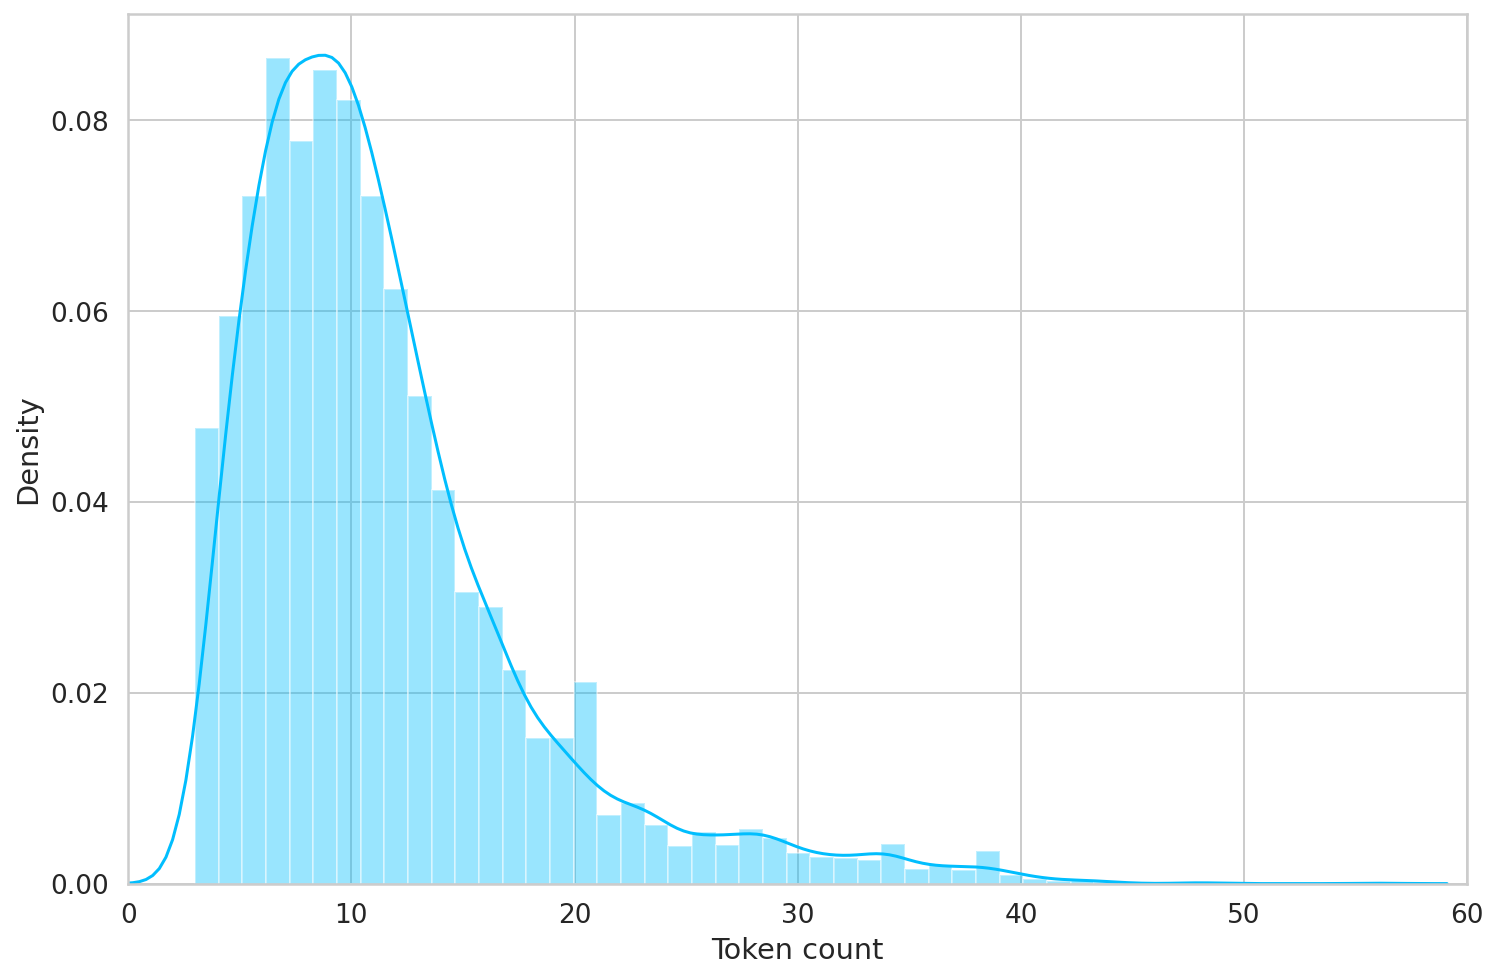

In [ ]:
token_lens = []

for sentence in list(train.Phrases):
  tokens = tokenizer.encode(sentence, truncation=True, max_length=64)
  token_lens.append(len(tokens))

print('Max length: ', max(token_lens))
print(' '*40)

sns.distplot(token_lens)
plt.xlim([0, 60]);
plt.xlabel('Token count');

Max length:  43
                                        


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


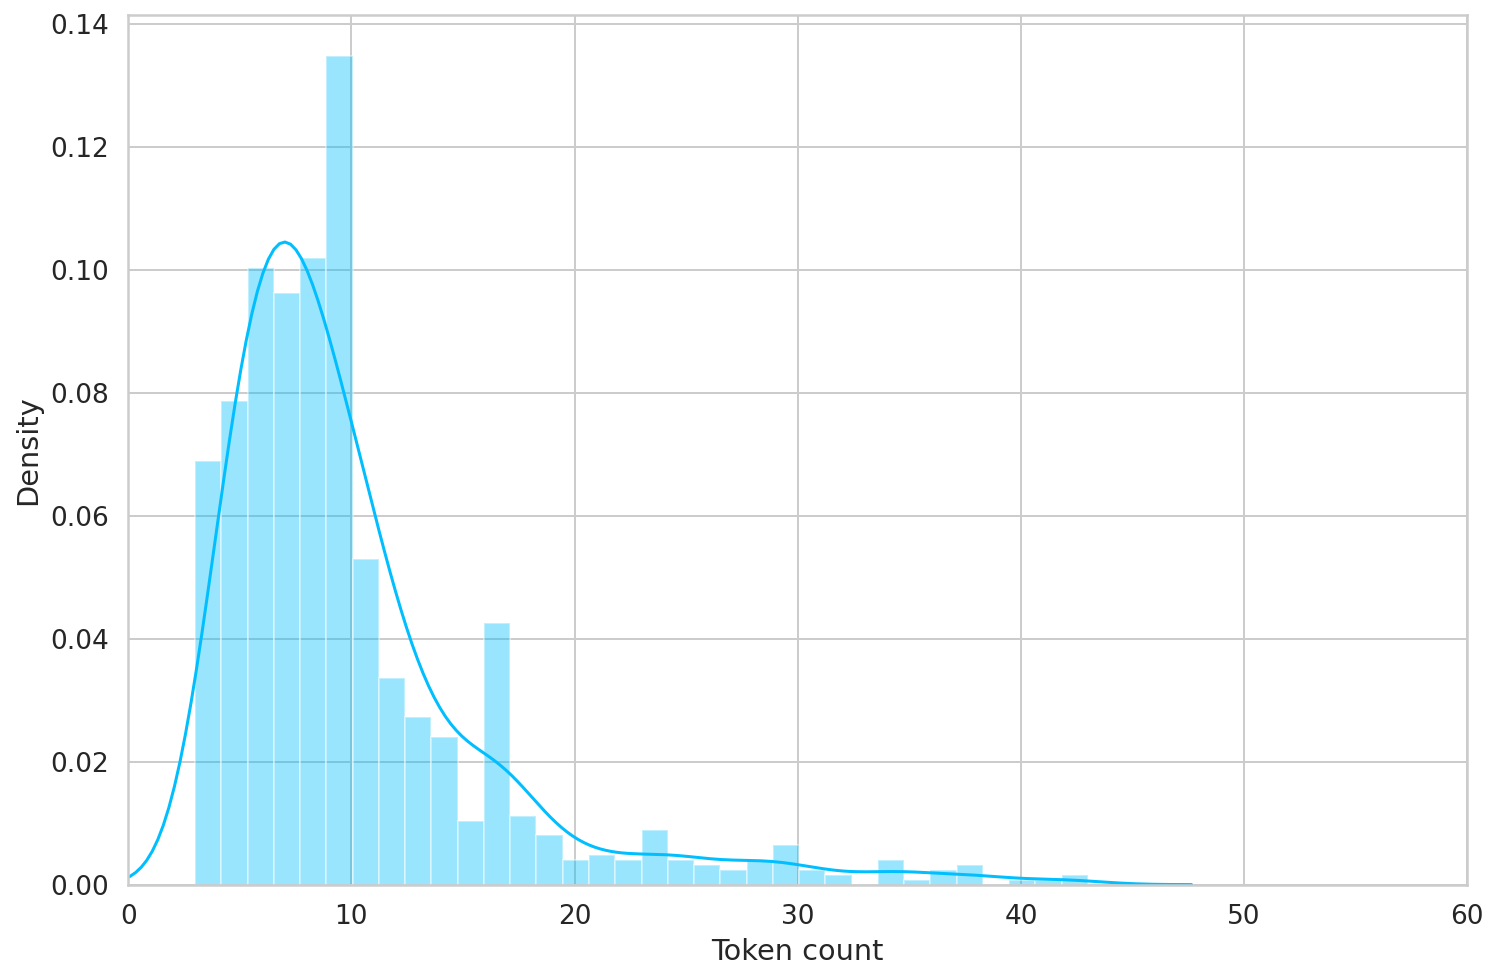

In [ ]:
token_lens = []

for sentence in list(valid.Phrases):
  tokens = tokenizer.encode(sentence, truncation=True, max_length=64)
  token_lens.append(len(tokens))

print('Max length: ', max(token_lens))
print(' '*40)

sns.distplot(token_lens)
plt.xlim([0, 60]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 64

In [ ]:
class SentenceDataset(Dataset):

  def __init__(self, sentences, labels, tokenizer, max_len):
    self.sentences = sentences
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.sentences)
  
  def __getitem__(self, item):
    sentence = str(self.sentences[item])
    label = self.labels[item]
    

    encoding = self.tokenizer.encode_plus(
      sentence,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'sentence_text': sentence,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(label, dtype=torch.long)
    }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = SentenceDataset(
    sentences=df.text.to_numpy(),
    labels=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
print([i for i in train_data_loader][0]['sentence_text'][0])
print([i for i in train_data_loader][0]['input_ids'][0])
print([i for i in train_data_loader][0]['attention_mask'][0])
print([i for i in train_data_loader][0]['labels'][0])

50 MW Floating Solar PV tender document
tensor([    0,  1096, 19370, 40480, 11400, 23774,  8780,  3780,     2,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor(0)


In [ ]:
data = next(iter(train_data_loader))

#print(data['sentence_text'])
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32])


In [ ]:
roberta_model = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

In [ ]:
class SentenceClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentenceClassifier, self).__init__()
    self.roberta = roberta_model
    self.drop = nn.Dropout(.4)
    self.out = nn.Linear(self.roberta.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.roberta(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentenceClassifier(train.Class_ID.nunique())
model = model.to(device)

print(model)

SentenceClassifier(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([32, 64])
torch.Size([32, 64])


In [ ]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-6, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()
  y_pred_tr = []
  y_true_tr = []

  losses = []
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = d["labels"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    preds = torch.argmax(outputs, dim=1)
    
    loss = loss_fn(outputs, labels)
    
    for i in preds.cpu().numpy():
      y_pred_tr.append(i)
    for i in labels.cpu().numpy():
      y_true_tr.append(i)
    
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return accuracy_score(y_true_tr, y_pred_tr), np.mean(losses)
         

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    
  model = model.eval()

  losses = []
    
  sentence_texts = []

  y_pred_val = []
  y_true_val = []

  with torch.no_grad():
    for d in data_loader:
      rev_text = d["sentence_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      
      preds = torch.argmax(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      for i in preds.cpu().numpy():
        y_pred_val.append(i)
      for i in labels.cpu().numpy():
        y_true_val.append(i)
      for i in rev_text:
        sentence_texts.append(i)

      losses.append(loss.item())

  return accuracy_score(y_true_val, y_pred_val), np.mean(losses), \
  y_pred_val, y_true_val, sentence_texts

In [ ]:
[i for i in val_data_loader][0]

{'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'input_ids': tensor([[    0,  6209,    89,  ...,     1,     1,     1],
         [    0,  6209,    89,  ...,     1,     1,     1],
         [    0, 10836,    47,  ...,     1,     1,     1],
         ...,
         [    0, 47456,  8881,  ...,     1,     1,     1],
         [    0, 14447,  2923,  ...,     1,     1,     1],
         [    0, 40545,     9,  ...,     1,     1,     1]]),
 'labels': tensor([ 47,  47,  33,  39,  42,   1,   2, 204, 262, 262,   0,   0,   0,   3,
          40, 259, 189,  47,   0,  47,  47,  16,  47,  47,  47, 259,   3, 318,
         204,  36,   0, 318]),
 'sentence_text': ['Is there a difference between the rates between HDB flats and private properties',
  'Is there a difference between the water rates between HDB flats and 

In [ ]:
device

device(type='cuda', index=0)

NN simply unable to learn

In [ ]:
%%time

history = defaultdict(list)
best_acc = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss: {train_loss}, Accuracy: {train_acc}')

  val_acc, val_loss, y_pred_val, y_true_val, sentence_texts = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_test)
  )

  print(f'Val loss: {val_loss}, Accuracy: {val_acc}')
  
  # saving to history
  history['train_acc'].append(train_acc.item())
  history['train_loss'].append(train_loss.item())
  history['val_acc'].append(val_acc.item())
  history['val_loss'].append(val_loss.item())
 

  # if current acc is larger than the previous one, save the model
  if val_acc > best_acc:
    torch.save(model.state_dict(), 'best_model_state.pt')
    best_acc = val_acc

Epoch 1/5
----------
Train loss: 5.453903786420035, Accuracy: 0.12895904260806768
Val loss: 5.61686635017395, Accuracy: 0.0820754716981132
Epoch 2/5
----------
Train loss: 5.217797590561039, Accuracy: 0.13391106984421747
Val loss: 5.2738946185392495, Accuracy: 0.0820754716981132
Epoch 3/5
----------
Train loss: 5.068103924442832, Accuracy: 0.11678530898586609
Val loss: 5.318771642797134, Accuracy: 0.0820754716981132
Epoch 4/5
----------
Train loss: 5.236883221679788, Accuracy: 0.05385329619312906
Val loss: 5.148431118796854, Accuracy: 0.0820754716981132
Epoch 5/5
----------
Train loss: 5.250207897853537, Accuracy: 0.05581347364077169
Val loss: 4.964716027764713, Accuracy: 0.1009433962264151
CPU times: user 18min 9s, sys: 21.2 s, total: 18min 31s
Wall time: 18min 34s
